# Using Pytorch to Generate Texts

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import numpy as np
import torch
import torch.nn as nn
import random


all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [0]:
! wget https://download.pytorch.org/tutorial/data.zip

In [0]:
! unzip /content/data.zip

# Get Data

In [0]:
def findFiles(path): 
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [0]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []

for filename in findFiles("/content/data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines



In [6]:
n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Vietnamese', 'French', 'Portuguese', 'Russian', 'Greek', 'German', 'Polish', 'Czech', 'Irish', 'Arabic', 'Japanese', 'English', 'Italian', 'Chinese', 'Korean', 'Spanish', 'Dutch', 'Scottish']
O'Neal


# Creating the Network

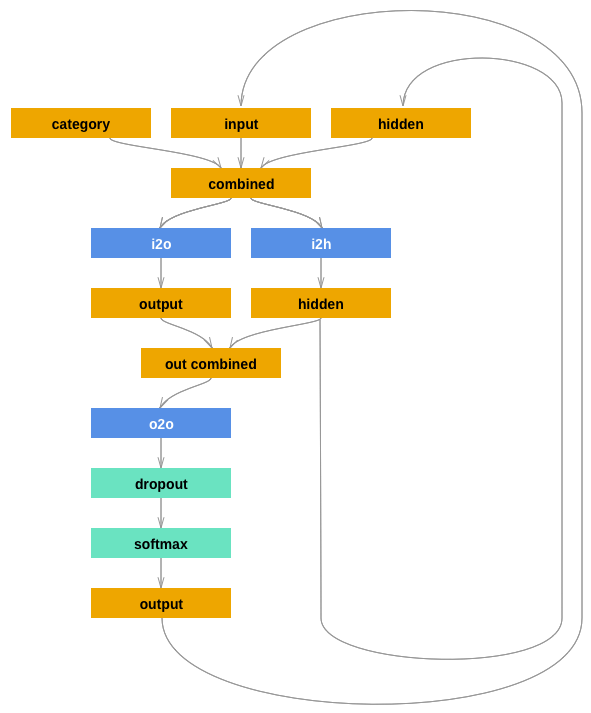

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training

In [10]:
print(category_lines.keys())

dict_keys(['Vietnamese', 'French', 'Portuguese', 'Russian', 'Greek', 'German', 'Polish', 'Czech', 'Irish', 'Arabic', 'Japanese', 'English', 'Italian', 'Chinese', 'Korean', 'Spanish', 'Dutch', 'Scottish'])


In [0]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [0]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

In [0]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


In [0]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [0]:
# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we’ll make a randomTrainingExample function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

In [0]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item() / input_line_tensor.size(0)


To keep track of how long training takes I am adding a timeSince(timestamp) function which returns a human readable string:

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples, and keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [0]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

In [45]:
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 3.1296
0m 29s (10000 10%) 2.7297
0m 43s (15000 15%) 4.1708
0m 57s (20000 20%) 1.8037
1m 12s (25000 25%) 1.9069
1m 26s (30000 30%) 3.0351
1m 41s (35000 35%) 2.9787
1m 55s (40000 40%) 2.8993
2m 9s (45000 45%) 2.4559
2m 23s (50000 50%) 2.3206
2m 38s (55000 55%) 2.2376
2m 52s (60000 60%) 2.1691
3m 7s (65000 65%) 2.9402
3m 21s (70000 70%) 1.9302
3m 35s (75000 75%) 3.2405
3m 49s (80000 80%) 2.8791
4m 3s (85000 85%) 3.1182
4m 17s (90000 90%) 2.1334
4m 32s (95000 95%) 2.4106
4m 46s (100000 100%) 2.2917
0m 14s (5000 5%) 3.1296
0m 29s (10000 10%) 2.7297
0m 43s (15000 15%) 4.1708
0m 57s (20000 20%) 1.8037
1m 12s (25000 25%) 1.9069
1m 26s (30000 30%) 3.0351
1m 41s (35000 35%) 2.9787
1m 55s (40000 40%) 2.8993
2m 9s (45000 45%) 2.4559
2m 23s (50000 50%) 2.3206
2m 38s (55000 55%) 2.2376
2m 52s (60000 60%) 2.1691
3m 7s (65000 65%) 2.9402
3m 21s (70000 70%) 1.9302
3m 35s (75000 75%) 3.2405
3m 49s (80000 80%) 2.8791
4m 3s (85000 85%) 3.1182
4m 17s (90000 90%) 2.1334
4m 32s (95000 95%) 2

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

    Create tensors for input category, starting letter, and empty hidden state
    Create a string output_name with the starting letter
    Up to a maximum output length,
        Feed the current letter to the network
        Get the next letter from highest output, and next hidden state
        If the letter is EOS, stop here
        If a regular letter, add to output_name and continue
    Return the final name


Rather than having to give it a starting letter, another strategy would have been to include a “start of string” token in training and have the network choose its own starting letter.

In [0]:
max_length = 20
def sample(category, start_letter="A"):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]

            if topi == n_letters - 1:
                break
            
            else:
                letter = all_letters[topi]
                output_name += letter
            
            input = inputTensor(letter)
    
        return output_name

In [0]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [49]:
samples('Russian', 'RUS')
print('-'* 100)
samples('German', 'GER')
print('-'* 100)
samples('Spanish', 'SPA')
print('-'* 100)
samples('Chinese', 'CHI')

Rovako
Uarini
Santovov
----------------------------------------------------------------------------------------------------
Gerter
Eerter
Roure
----------------------------------------------------------------------------------------------------
Sollan
Paran
Aller
----------------------------------------------------------------------------------------------------
Cha
Han
Iun
